In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
ls

gdrive/  sample_data/


In [0]:
import os
os.chdir("gdrive/My Drive")

In [4]:
ls

det2.py                                          single.ipynb
images/                                          split.ipynb
Mask_RCNN/                                       stage1_sample_submission.csv
Mask_RCNN-master/                                stage1_solution.csv
multi_class_.ipynb                               stage1_train_labels.csv
multi_class_lr0.001_epoch7_weight0004_gpu.ipynb  test.ipynb
multi.ipynb                                      Untitled0.ipynb


In [5]:
# Enable this for some more verbose info.
debugging = False
#import tensorflow as tf
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


# Common imports

In [6]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import random
import collections

# Root directory of the project
ROOT_DIR = os.path.abspath("./Mask_RCNN-master")
ROOT_IMAGE_DIR = os.path.abspath("./images/")

# Path to the dataset (note this is a shared images directory)
dataset_path = os.path.join(ROOT_IMAGE_DIR, "fish")

models_dir = os.path.join(ROOT_DIR, "models/")

print("base dataset dir:", dataset_path)
print("base modesl dir:", models_dir)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.model import log

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

base dataset dir: /content/gdrive/My Drive/images/fish
base modesl dir: /content/gdrive/My Drive/Mask_RCNN-master/models/


In [0]:
# for visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

%matplotlib inline

In [0]:
# For Config and Dataset 
sys.path.append(os.path.join(ROOT_DIR, ""))  # To find local version
import det as det

# Image setting

In [9]:
class InferenceConfig(det.DetConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
#    NUM_CLASSES = 2 # For BG + Others
    
inf_config = InferenceConfig('Fish', ['Fish'])
inf_model = modellib.MaskRCNN(mode="inference", 
                              config=inf_config,
                              model_dir=models_dir)

inf_config.display()

# Find last trained weights
#weights_path = inf_model.find_last()[1]

# When testing use the latest, for demo use stable model
weights_path = os.path.join(models_dir, "fish20190130T0430/mask_rcnn_fish_0020.h5")
# weights_path = os.path.join(models_dir, "wolf20180516T0136_mask_rcnn_wolf_0075.h5")


print("Using latest weights: ", weights_path)

inf_model.load_weights(weights_path, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.

Configurations:
ACTIVATION                     relu
ALL_CLASS_NAMES                ['BG', 'Fish']
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CLASS_NAMES                    ['Fish']
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.

In [0]:
import glob

def detect_instance(class_names, image_test_dir):
    """
    class_names: list of class names of the dataset
    image_filenames: list of images to analyze
    """

    det_filenames = sorted(glob.glob(image_test_dir+'/*'))

    for f in det_filenames:
        print("Processing image {}".format(f))

        test_img = plt.imread(f)
        print(test_img.shape)

        plt.imshow(test_img)
        # visualize.display_images([test_img])

        # Included in the results from detect are the found:
        # class_ids,their scores and masks.
        results = inf_model.detect([test_img], verbose=1)[0]

        print("Objects detected: ", len(results['class_ids']))

        # Visualize results
        visualize.display_instances(test_img, 
                                    results['rois'], 
                                    results['masks'], 
                                    results['class_ids'], 
                                    class_names, 
                                    results['scores'])

        print(results['class_ids'])

In [0]:
import math

def detect_instances(class_names, image_test_dir):
    """
    class_names: list of class names of the dataset
    image_filenames: list of images to analyze
    """
        
    det_filenames = sorted(glob.glob(image_test_dir+'/*'))

    fig = plt.figure(figsize=(16,10))

    n_cols = 3
    n_rows = math.ceil(len(det_filenames) / n_cols) 
    
    
    for i, f in enumerate(det_filenames):
        
        print("Processing image {}".format(f))
        
        ax = plt.subplot( n_rows, n_cols, i+1)

        test_img = plt.imread(f)

        # Included in the results from detect are the found:
        # class_ids,their scores and masks.
        results = inf_model.detect([test_img], verbose=1)[0]

        print("Objects detected: ", len(results['class_ids']))

        # Visualize results
        visualize.display_instances(test_img, 
                                    results['rois'], 
                                    results['masks'], 
                                    results['class_ids'], 
                                    class_names, 
                                    results['scores'],
                                    ax=ax)

        print(results['class_ids'])

In [0]:
def load_mask(image_id, detect_result):
    """
    image_info = self.image_info[image_id]
    if image_info["source"] not in self.class_names:
        print("warning: source {} not part of our classes, delegating to parent.".format(image_info["source"]))
        return super(self.__class__, self).load_mask(image_id)
    """
    mask = detect_result['masks']
    class_ids = detect_result['class_ids']

    return mask, class_ids

Processing image /content/gdrive/My Drive/images/fish/train/acanthopagrus_berda_1.jpg
Processing 1 images
image                    shape: (400, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Objects detected:  1
[1]
Processing image /content/gdrive/My Drive/images/fish/train/acanthopagrus_berda_2.jpg
Processing 1 images
image                    shape: (400, 649, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

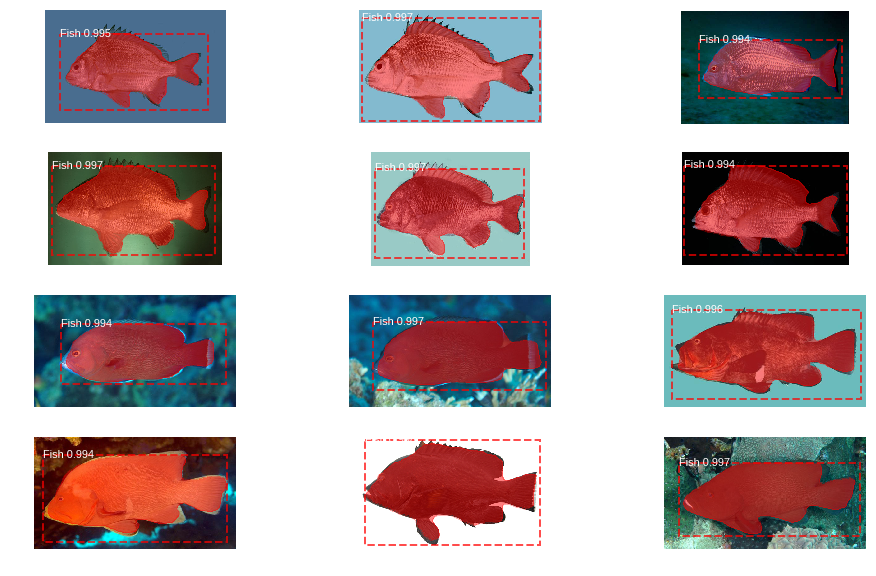

In [13]:
image_test_dir = os.path.join(ROOT_IMAGE_DIR, "fish/train/")

if debugging:
    r = detect_instance(inf_config.ALL_CLASS_NAMES, image_test_dir)
else:
    r = detect_instances(inf_config.ALL_CLASS_NAMES, image_test_dir)

# Augmentation

In [0]:
# The imgaug library is pretty flexible and make different types of augmentation possible. 
# The deterministic setting is used because any spatial changes to the image must also be 
# done to the mask. There are also some augmentors that are unsafe to apply. From the mrcnn
# library: 
# Augmentors that are safe to apply to masks: 
# ["Sequential", "SomeOf", "OneOf", "Sometimes","Fliplr", 
# "Flipud", "CropAndPad", "Affine", "PiecewiseAffine"]
# Affine, has settings that are unsafe, so always
# test your augmentation on masks

import imgaug as ia
from imgaug import augmenters as iaa

ia.seed(1)

# http://imgaug.readthedocs.io/en/latest/source/augmenters.html#sequential
seq_of_aug = iaa.Sequential([
    iaa.Crop(percent=(0, 0.1)), # random crops
    
    # horizontally flip 50% of the images
    #iaa.Fliplr(0.5), # Does not make sense for signs

    # Gaussian blur to 50% of the images
    # with random sigma between 0 and 0.5.
    iaa.Sometimes(0.4,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    
    # Apply affine transformations to each image.
    # Scale/zoom them from 90% 5o 110%
    # Translate/move them, rotate them
    # Shear them slightly -2 to 2 degrees.
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-5, 5),
        shear=(-2, 2)
    )
], random_order=True) # apply augmenters in random order

# Train

In [0]:
print("dataset dir:", dataset_path)
print("modesl dir:", models_dir)

dataset dir: /content/gdrive/My Drive/images/fish
modesl dir: /content/gdrive/My Drive/Mask_RCNN-master/models/


In [0]:
# Setup configuration
config = det.DetConfig('fish',['fish','acanthopagrus_berda', 'aethaloperca_rogaa'])
config.display()


Configurations:
ACTIVATION                     relu
ALL_CLASS_NAMES                ['BG', 'fish', 'acanthopagrus_berda', 'aethaloperca_rogaa']
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CLASS_NAMES                    ['fish', 'acanthopagrus_berda', 'aethaloperca_rogaa']
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE               

In [0]:
# Create the model
model = modellib.MaskRCNN(mode='training', 
                          config=config,
                          model_dir=models_dir)

model.keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
# Load the weights

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(models_dir, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
else:
    print("using existing ", COCO_MODEL_PATH)
    
# For the coco dataset exclude the last layers because 
# it requires a matching number of classes
print("loading...", end='')
model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

print("loaded.")

using existing  /content/gdrive/My Drive/Mask_RCNN-master/models/mask_rcnn_coco.h5
loading...loaded.


In [0]:
import random
def random_choice(count, train_n):
  choice = list()
  for i in range(train_n):
    number = random.randrange(1, count+1)
    while number in choice:
      number = random.randrange(1, count+1)
    choice.append(number)
  choice.sort()
    
  return choice

In [0]:
def generate_val_index(count, train_index):
  val_index = list()
  
  for i in range(len(count)):
    no_choice = list()
	
  for j in range(1, count[i]+1):
    if j not in train_index[i]:
      no_choice.append(j)
    val_index.append(no_choice)

  return val_index


In [0]:
def generate_filename(class_names, index):
  full_names = list()
  
  for i in range(len(index)):
    name = class_names.replace(" ", "_")
    name = "%s_%d.jpg"%(name, index[i])
    full_names.append(name)
    
  return full_names
    

In [0]:
def clean_name(file_name):
  file_name = file_name[:-6]
  name = file_name.replace("_", " ")
  name = name.replace("~", " ")
  name = name.rstrip()
  
  return name

In [0]:
def clean_dataset(file_list):
  file_names = list()
  
  for file_name in file_list:
    name = clean_name(file_name)
    file_names.append(name)
    
    return file_names

In [0]:
def get_unique_classnames(file_names):
  class_names = list()
  for i in file_names:
    if i not in class_names:
      class_names.append(i)
      
  return class_names

def count_each_class(file_names, class_names):
  count = list()
  for i in class_names:
    count.append(file_names.count(i))
    
  return count

In [0]:
def create_datasets(dataset_dir, config, train_pct=.8, randomize=True):
  # 1. dataset_dir 에서 파일 이름읽어오기
	file_list = os.listdir(dataset_dir)
	file_list.sort()
	del file_list[0]

	# 파일 이름에서 .jpg, _ 지우기
	file_names = FishDataset.clean_name(file_list)
	
	# 파일 이름에서 클래스 이름 가져오기 
	class_names = FishDataset.get_unique_classnames(file_names)

	# 2. class별 개수 세기
	count = count_each_class(file_names, class_names)

	# csv 파일 만들어 놓기 
	save_path = os.path.join(ROOT_DIR, "/species.csv")
	f = open(save_path, 'w', encoding='utf-8', newline='')
	writer = csv.writer(f)
	writer.writerows(zip(class_names, count))
	f.close()

	# 3. class별 할당 train 개수 세기
	train_n = list()
  
  for i in range(len(count)):
    if(count[i]<5):
      n = math.floor(count[i]*train_pct)
      train_n.append(n)
    else:
      n = math.ceil(count[i]*train_pct)
      train_n.append(n)
  print(train_n)
  # 4. class 이동하면서 random 숫자 생성
  train_index = list()
  
  for i in range(len(count)):
  	choice = random_choice(count[i], train_n[i])
  	train_index.append(choice)

  val_index = generate_val_index(count, train_index)

  # 5. class 이름에서 파일 이름 생성
  train_set = list()
  val_set = list()
  for i in range(len(class_names)):
  	file_set = generate_filename(class_names[i], train_index[i])
  	train_set.append(file_set)
  	file_set = generate_filename(class_names[i], val_index[i])
  	val_set.append(file_set)

  # 6. train/ val 에 저장하기
  return train_set, val_set

IndentationError: ignored

In [0]:
def train(model, dataset_path, epochs=30):
    """Train the model."""
    
    # Create the train and val dataset.
    dataset_train, dataset_val = det.create_datasets(dataset_path+'/train', config)

    # Prepare them
    dataset_train.prepare()
    dataset_val.prepare()

    # Experiment with training options.
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    history = model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=epochs,
                layers='heads', 
                augmentation=seq_of_aug
                )
    
    return history

In [0]:
history = train(model, dataset_path, 10)

FileNotFoundError: ignored

In [0]:
class InferenceConfig(det.DetConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
inf_config = InferenceConfig('fish', ['fish','acanthopagrus_berda', 'aethaloperca_rogaa'])

inf_model = modellib.MaskRCNN(mode="inference", 
                              config=inf_config,
                              model_dir=models_dir)

inf_config.display()

# Find last trained weights
weights_path = inf_model.find_last()[1]

# enabled for testing
#weights_path = os.path.join(models_dir, "sign20180508T1523_mask_rcnn_sign_0075.h5")
weights_path = os.path.join(models_dir, "fish20190126T0833/mask_rcnn_fish_0010.h5")

print("Using weights: ", weights_path)

inf_model.load_weights(weights_path, by_name=True)

In [0]:
import glob

def detect_instance(class_names, image_test_dir):
    """
    class_names: list of class names of the dataset
    image_filenames: list of images to analyze
    """

    det_filenames = sorted(glob.glob(image_test_dir+'/*'))

    for f in det_filenames:
        print("Processing image {}".format(f))

        test_img = plt.imread(f)
        print(test_img.shape)

        plt.imshow(test_img)
        # visualize.display_images([test_img])

        # Included in the results from detect are the found:
        # class_ids,their scores and masks.
        results = inf_model.detect([test_img], verbose=1)[0]

        print("Objects detected: ", len(results['class_ids']))

        # Visualize results
        visualize.display_instances(test_img, 
                                    results['rois'], 
                                    results['masks'], 
                                    results['class_ids'], 
                                    class_names, 
                                    results['scores'])

        print(results['class_ids'])

In [0]:
import time

def detect_instances(class_names, image_test_dir):
    """
    class_names: list of class names of the dataset
    image_filenames: list of images to analyze
    """
        
    det_filenames = sorted(glob.glob(image_test_dir+'/*'))

    fig = plt.figure(figsize=(16,10))

    n_cols = 3
    n_rows = math.ceil(len(det_filenames) / n_cols) 
    
    
    for i, f in enumerate(det_filenames):
        
        print("Processing image {}".format(f))
        
        ax = plt.subplot( n_rows, n_cols, i+1)

        test_img = plt.imread(f)

        start_time = time.time()
        
        # Included in the results from detect are the found:
        # class_ids,their scores and masks.
        results = inf_model.detect([test_img], verbose=1)[0]
        
        elapsed_time = time.time() - start_time

        print("Elapsed time: {:.4f}, Objects detected: {}".format( elapsed_time, len(results['class_ids'])))

        # Visualize results
        visualize.display_instances(test_img, 
                                    results['rois'], 
                                    results['masks'], 
                                    results['class_ids'], 
                                    class_names, 
                                    results['scores'],
                                    ax=ax)

        print(results['class_ids'])

In [0]:
image_test_dir = os.path.join(dataset_path, "val/")

if debugging:
    r = detect_instance(inf_config.ALL_CLASS_NAMES, image_test_dir)
else:
    r = detect_instances(inf_config.ALL_CLASS_NAMES, image_test_dir)

In [0]:
image = skimage.io.imread(os.path.join(IMAGE_DIR,image_name))
results = model.detect([image], verbose=1)
r = results[0]



In [0]:
visualize.save_image(image, image_name, r['rois'], r['masks'],
    r['class_ids'],r['scores'],coco_class_names,
    filter_classs_names=['bottle', 'wine glass'],scores_thresh=0.9,mode=0)